In [ ]:
#import the dataset 
from keras.datasets import fashion_mnist
%pip install wandb -q
import wandb
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import matplotlib.pyplot as plt

In [ ]:
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'hidden_layers': {
            'values': [3,4,5]
        },
        'size_layer': {
            'values': [32, 64, 128]
        },
        #'weight decay': {
         #   'values': [0,0.0005, 0.5]
        #},
        'learning_rate': {
            'values': [ 1e-3, 1e-4]
        },
        'optimizer': {
            'values': ['nadam','vanilla','momentum','rmsprop']
        },
        'batch_size':{
            'values': [16,32,64]
        },
        #'weight_init':{
         #   'values': ['random','xavier']
        #},
        'activation': {
            'values': ['tanh','sigmoid', 'ReLU']
        }
    }
}

In [ ]:
#import the required libraries 
from matplotlib import pyplot
import numpy as np

In [ ]:
#load the data into train and test 
(X_trainval,y_trainval),(X_test,y_test)=fashion_mnist.load_data()
#pyplot.imshow(X_train[2])
indices = np.random.permutation(X_trainval.shape[0])
training_idx= indices[:54000]
validation_idx = indices[54000:]
#print(validation_idx)
X_train, X_val = X_trainval[training_idx,:,:], X_trainval[validation_idx,:,:]
y_train,y_val=y_trainval[training_idx],y_trainval[validation_idx]

In [ ]:
noOfImages = X_train.shape[0]
print(noOfImages)
X_train = (1.0/255)*np.array([X_train[i].flatten() for i in range(0,X_train.shape[0])])
#X_train = np.array([X_train[i].flatten() for i in range(0,noOfImages)])
print(X_train.shape)
X_test =(1.0/255)*np.array([X_test[i].flatten() for i in range(0,X_test.shape[0])])
X_val =(1.0/255)*np.array([X_val[i].flatten() for i in range(0,X_val.shape[0])])

print(X_test.shape)
print(X_train.shape)
print(X_val.shape)


54000
(54000, 784)
(10000, 784)
(54000, 784)
(6000, 784)


In [ ]:
print(X_train[0])

[0.         0.         0.         0.00392157 0.         0.00392157
 0.         0.         0.         0.         0.17647059 0.63529412
 0.45490196 0.45098039 0.44705882 0.47058824 0.64313725 0.30980392
 0.         0.         0.         0.         0.         0.00392157
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.19215686
 0.59607843 0.91764706 0.88627451 0.96862745 0.97647059 0.96470588
 1.         0.96078431 0.9254902  0.91372549 0.98823529 0.64313725
 0.25098039 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.42352941 0.78823529 0.90588235 0.91764706 0.87843137
 0.85490196 0.85490196 0.86666667 0.77254902 0.80784314 0.85882353
 0.84705882 0.87058824 0.88627451 0.9372549  0.92941176 0.83529412
 0.43137255 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.34117647 0.95686275
 0.8627451  0.84705882 0.83

In [ ]:

l=10 #output classes
noOfneuronsEach=[120,20]
noOfHiddenLayers=len(noOfneuronsEach)
inputNeuronSize=X_train.shape[1]
print(inputNeuronSize)
parameters={}
batchSize=600
activate="sigmoid"
iterations=10
eta=1
#eta=0.001   #for rmsprop higher learning rate gradients explode causing overflow
#eta=0.002 #Nadam
#input W
#initialization
parameters['W'+str(1)] =np.random.uniform(low=-0.5,high=0.5,size=(noOfneuronsEach[0], inputNeuronSize))
parameters['b'+str(1)]= np.random.uniform(low=-0.5,high=0.5,size=(noOfneuronsEach[0],1))
#parameters['W'+str(1)] =0+1.5*np.random.randn(noOfneuronsEach[0], inputNeuronSize)
#parameters['b'+str(1)]= 0+1.5*np.random.randn(noOfneuronsEach[0],1)
for i in range(2,noOfHiddenLayers+1):
  parameters['W'+str(i)] = np.random.uniform(low=-0.5,high=0.5,size=(noOfneuronsEach[i-1], noOfneuronsEach[i-2]))
  parameters['b'+str(i)]= np.random.uniform(low=-0.5,high=0.5,size=(noOfneuronsEach[i-1],1))
  #parameters['W'+str(i)] = 0+1.5*np.random.randn(noOfneuronsEach[i-1], noOfneuronsEach[i-2])
  #parameters['b'+str(i)]= 0+1.5*np.random.randn(noOfneuronsEach[i-1],1)
#Output W
parameters['W'+str(noOfHiddenLayers+1)] = np.random.uniform(low=-0.5,high=0.5,size=(l, noOfneuronsEach[-1]))
parameters['b'+str(noOfHiddenLayers+1)]= np.random.uniform(low=-0.5,high=0.5,size=(l,1))
#parameters['W'+str(noOfHiddenLayers+1)] = 0+1.5*np.random.randn(l, noOfneuronsEach[-1])
#parameters['b'+str(noOfHiddenLayers+1)]= 0+1.5*np.random.randn(l,1)


784


In [ ]:
def softmax(X):
  X=np.exp(X)
  sum=np.sum(X,axis=0)
  return X/sum 


In [ ]:
def sigmoidFunc(X):

  return 1.0/(1.0+np.exp(-X))
  #return res

In [ ]:
def sigmoidDash(X):
  return sigmoidFunc(X)*(1-sigmoidFunc(X))

In [ ]:
def tanhFunc(X):
  return ((np.exp(X)-np.exp(-X))/(np.exp(X)+np.exp(-X)))

In [ ]:
def tanhDash(X):
  return (1-(tanhFunc(X)**2))

In [ ]:
def reluFunc(X): 
  return X*(X>0.0)

In [ ]:
def reluDash(X):
  X[X<= 0.0]=0.0
  X[X>0.0]=1.0
  return X

In [ ]:
def gDash(X):
  if activate=='sigmoid':
    return sigmoidDash(X)
  elif activate=='tanh':
    return tanhDash(X)
  elif activate=='ReLU':
    return reluDash(X)

In [ ]:
def activationFunc(X):
  if activate=='sigmoid':
    return sigmoidFunc(X)
  elif activate=='tanh':
    return tanhFunc(X)
  elif activate=='ReLU':
    return reluFunc(X)

In [ ]:
def forwardPropagation(X,parameters):
  preactivation={}
  activation={}
  activation['h0']=X.T
 
  for k in range(1,noOfHiddenLayers+1):
    preactivation['a'+str(k)]=np.dot(parameters['W'+str(k)],activation['h'+str(k-1)])+parameters['b'+str(k)]
    activation['h'+str(k)]=activationFunc(preactivation['a'+str(k)])
 
  preactivation['a'+str(noOfHiddenLayers+1)]=np.dot(parameters['W'+str(noOfHiddenLayers+1)],activation['h'+str(noOfHiddenLayers)])+parameters['b'+str(noOfHiddenLayers+1)]
  y=softmax(preactivation['a'+str(noOfHiddenLayers+1)])    

  return (preactivation,activation,y)



In [ ]:
def backPropagation(parameters,activation,preactivation,yhat,X,y_train):
  grads={}
  eIndicator=np.zeros((10,X.shape[0]))
  eIndicator[y_train,np.arange(X.shape[0])]=1
  #cross entropy
  grads['a'+str(noOfHiddenLayers+1)]= -(eIndicator-yhat)
  #squared loss 
  #r=(yhat-eIndicator)*yhat
  #for i in range(X.shape[0]):
    #r[:,i]= np.dot((np.eye(10)-yhat[:,i]),r[:,i])
  #yhatl=np.apply_along_axis(max,0,yhatl)
  #square=np.apply_along_axis(sum,0,yhat-eIndicator)
  #grads['a'+str(noOfHiddenLayers+1)]= 2*r
  for j in range(noOfHiddenLayers+1,0,-1):
    grads['W'+str(j)]= np.dot(grads['a'+str(j)],activation['h'+str(j-1)].T)
 
    grads['b'+str(j)]= np.sum(grads['a'+str(j)],axis=1,keepdims=True)
    
    grads['h'+str(j-1)]=np.dot(parameters['W'+str(j)].T,grads['a'+str(j)])
    
    if (j!=1):
      grads['a'+str(j-1)]=grads['h'+str(j-1)]*gDash(preactivation['a'+str(j-1)])
  return grads


In [ ]:
def squareLoss(yhat,y_train,X):
  eIndicator=np.zeros((10,X.shape[0]))
  eIndicator[y_train,np.arange(X.shape[0])]=1
  return np.sum((yhat-eIndicator)**2)

In [ ]:
def Loss(yhat,y_train,X):
  eIndicator=np.zeros((10,X.shape[0]))
  eIndicator[y_train,np.arange(X.shape[0])]=1
  eIndicator=eIndicator*yhat
  eIndicator=eIndicator.sum(axis=0)
  eIndicator=np.log(eIndicator)
  return -sum(eIndicator)


In [ ]:
sweep_id = wandb.sweep(sweep_config, entity="aeaswar81", project="testing")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: zez6qnyv
Sweep URL: https://wandb.ai/aeaswar81/testing/sweeps/zez6qnyv


In [ ]:
def train():
 # config_defaults = {
        #'epochs': 2,
       # 'batch_size': 128,
        # 'activation': 'sigmoid',
      #  'optimizer': 'nadam',
     #   'size_layer':32,
    #    'hidden_layers':3
   # }
  
  wandb.init()
  config = wandb.config
  n="hl_"+str(config.hidden_layers)+"_bs_"+str(config.batch_size)+"_ac_"+str(config.activation)
  wandb.run.name=n
  

  parameters_reset(config.size_layer,config.hidden_layers,config.batch_size,config.epochs,config.learning_rate,config.activation)
  if config.optimizer=='nadam':
    nadam()
  elif config.optimizer=='rmsprop':
    rmsProp()
  elif config.optimizer=='momentum':
    momentumGD()
  elif config.optimizer=='vanilla':
    vanillagradDescent()


In [ ]:
def parameters_reset(noOfneurons,hiddenlayers,batch,iter,learning,activation):
  global l 
  global noOfneuronsEach
  global noOfHiddenLayers
  global inputNeuronSize
  global parameters
  global batchSize
  global iterations
  global eta
  global activate
  activate=activation
  l=10 #output classes
  noOfneuronsEach=[]
  for i in range(hiddenlayers):
    noOfneuronsEach.append(noOfneurons)
  noOfHiddenLayers=hiddenlayers
  inputNeuronSize=X_train.shape[1]
  #print(inputNeuronSize)
  parameters={}
  batchSize=batch
  iterations=iter
  #eta=1   
  #eta=0.001   #for rmsprop higher learning rate gradients explode causing overflow
  #eta=0.002 #Nadam
  eta=learning
  #input W
  #initialization
  parameters['W'+str(1)] =np.random.uniform(low=-0.5,high=0.5,size=(noOfneuronsEach[0], inputNeuronSize))
  parameters['b'+str(1)]= np.random.uniform(low=-0.5,high=0.5,size=(noOfneuronsEach[0],1))
  #parameters['W'+str(1)] =0+1.5*np.random.randn(noOfneuronsEach[0], inputNeuronSize)
  #parameters['b'+str(1)]= 0+1.5*np.random.randn(noOfneuronsEach[0],1)
  for i in range(2,noOfHiddenLayers+1):
    parameters['W'+str(i)] = np.random.uniform(low=-0.5,high=0.5,size=(noOfneuronsEach[i-1], noOfneuronsEach[i-2]))
    parameters['b'+str(i)]= np.random.uniform(low=-0.5,high=0.5,size=(noOfneuronsEach[i-1],1))
  #parameters['W'+str(i)] = 0+1.5*np.random.randn(noOfneuronsEach[i-1], noOfneuronsEach[i-2])
  #parameters['b'+str(i)]= 0+1.5*np.random.randn(noOfneuronsEach[i-1],1)    
  #Output W
  parameters['W'+str(noOfHiddenLayers+1)] = np.random.uniform(low=-0.5,high=0.5,size=(l, noOfneuronsEach[-1]))
  parameters['b'+str(noOfHiddenLayers+1)]= np.random.uniform(low=-0.5,high=0.5,size=(l,1))
  #parameters['W'+str(noOfHiddenLayers+1)] = 0+1.5*np.random.randn(l, noOfneuronsEach[-1])
  #parameters['b'+str(noOfHiddenLayers+1)]= 0+1.5*np.random.randn(l,1)

In [ ]:
def vanillagradDescent():
  t=0
  while(t < iterations):
    print("Epoch ",t)
    #print(parameters)
    mini=0
    while(mini<(noOfImages/batchSize)):
      #print("Batch ",mini)
      X_mini=X_train[(mini*batchSize):((mini+1)*batchSize-1)]
      y_mini=y_train[(mini*batchSize):((mini+1)*batchSize-1)]
      preactivation,activation,yhat=forwardPropagation(X_mini,parameters)
      gradients=backPropagation(parameters,activation,preactivation,yhat,X_mini,y_mini)
      #print("gradients",gradients)
      for i in range(1,noOfHiddenLayers+2):
        parameters['W'+str(i)] -=  eta*(1.0/X_mini.shape[0])*gradients['W'+str(i)]
        parameters['b'+str(i)] -= eta*(1.0/X_mini.shape[0])*gradients['b'+str(i)]
      mini+=1
    _,_,yhat=forwardPropagation(X_train,parameters)
    _,_,yhatval=forwardPropagation(X_val,parameters)
    #square loss
    #print("loss after epoch ",squareLoss(yhat,y_train,X_train))
    #cross entropy loss
    print("loss after epoch ",Loss(yhat,y_train,X_train))
    
    t+=1
    wandb.log({'val_loss':Loss(yhatval,y_val,X_val),'loss':Loss(yhat,y_train,X_train),'val_accuracy':predict(X_val,y_val) ,'accuracy':predict(X_train,y_train),'epochs': t})
#vanillagradDescent()


Epoch  0
loss after epoch  33222.60839739312
Epoch  1
loss after epoch  30141.0625234503
Epoch  2
loss after epoch  28576.107792591738
Epoch  3
loss after epoch  27154.571045355493
Epoch  4
loss after epoch  26041.945854135167
Epoch  5
loss after epoch  25184.851904944462
Epoch  6
loss after epoch  24465.99496246063
Epoch  7
loss after epoch  23816.861447008432
Epoch  8
loss after epoch  23221.54877148942
Epoch  9
loss after epoch  22685.158563268815


In [ ]:
def momentumGD():
  #initialization
  prevW={}
  prevb={}
  gamma=0.9
  prevW['W'+str(1)] =np.zeros((noOfneuronsEach[0], inputNeuronSize))
  prevb['b'+str(1)]= np.zeros((noOfneuronsEach[0],1))
  for i in range(2,noOfHiddenLayers+1):
    prevW['W'+str(i)] = np.zeros((noOfneuronsEach[i-1], noOfneuronsEach[i-2]))
    prevb['b'+str(i)]= np.zeros((noOfneuronsEach[i-1],1))
  prevW['W'+str(noOfHiddenLayers+1)] = np.zeros((l, noOfneuronsEach[-1]))
  prevb['b'+str(noOfHiddenLayers+1)]= np.zeros((l,1))
  t=0
  while(t<iterations):
    print("Epoch ",t)
    mini=0
    while(mini<(noOfImages/batchSize)):
      #print("Batch ",mini)
      X_mini=X_train[(mini*batchSize):((mini+1)*batchSize-1)]
      y_mini=y_train[(mini*batchSize):((mini+1)*batchSize-1)]
      preactivation,activation,yhat=forwardPropagation(X_mini,parameters)
      gradients=backPropagation(parameters,activation,preactivation,yhat,X_mini,y_mini)
      #print("gradients",gradients)
      for i in range(1,noOfHiddenLayers+2):
        w=gamma*prevW['W'+str(i)]+eta*(1.0/X_mini.shape[0])*gradients['W'+str(i)]
        b=gamma*prevb['b'+str(i)]+eta*(1.0/X_mini.shape[0])*gradients['b'+str(i)]
        parameters['W'+str(i)] -=  w
        parameters['b'+str(i)] -=  b
        prevW['W'+str(i)]=w
        prevb['b'+str(i)]=b
      mini+=1
    _,_,yhat=forwardPropagation(X_train,parameters)
    _,_,yhatval=forwardPropagation(X_val,parameters)
    #print("loss after epoch ",Loss(yhat,y_train,X_train))
    
    t+=1
    wandb.log({'val_loss':Loss(yhatval,y_val,X_val),'loss':Loss(yhat,y_train,X_train),'val_accuracy':predict(X_val,y_val) ,'accuracy':predict(X_train,y_train),'epochs': t})




In [ ]:
def rmsProp():
  #initialization
  prevW={}
  prevb={}
  epsilon=1e-8
  beta=0.9
  prevW['W'+str(1)] =np.zeros((noOfneuronsEach[0], inputNeuronSize))
  prevb['b'+str(1)]= np.zeros((noOfneuronsEach[0],1))
  for i in range(2,noOfHiddenLayers+1):
    prevW['W'+str(i)] = np.zeros((noOfneuronsEach[i-1], noOfneuronsEach[i-2]))
    prevb['b'+str(i)]= np.zeros((noOfneuronsEach[i-1],1))
  prevW['W'+str(noOfHiddenLayers+1)] = np.zeros((l, noOfneuronsEach[-1]))
  prevb['b'+str(noOfHiddenLayers+1)]= np.zeros((l,1))
  t=0
  while(t<iterations):
    print("Epoch ",t)
    mini=0
    while(mini<(noOfImages/batchSize)):
      #print("Batch ",mini)
      X_mini=X_train[(mini*batchSize):((mini+1)*batchSize-1)]
      y_mini=y_train[(mini*batchSize):((mini+1)*batchSize-1)]
      preactivation,activation,yhat=forwardPropagation(X_mini,parameters)
      gradients=backPropagation(parameters,activation,preactivation,yhat,X_mini,y_mini)
      #print("gradients",gradients)
      for i in range(1,noOfHiddenLayers+2):
        prevW['W'+str(i)]= beta*prevW['W'+str(i)]+(1.0 - beta)* (gradients['W'+str(i)]**2)
        prevb['b'+str(i)]= beta*prevb['b'+str(i)]+(1.0 - beta)* (gradients['b'+str(i)]**2)
        
        parameters['W'+str(i)] -=  ((eta/np.sqrt(prevW['W'+str(i)]+epsilon))*gradients['W'+str(i)])
        parameters['b'+str(i)] -=  ((eta/np.sqrt(prevb['b'+str(i)]+epsilon))*gradients['b'+str(i)])
      mini+=1
    _,_,yhat=forwardPropagation(X_train,parameters)
    _,_,yhatval=forwardPropagation(X_val,parameters)
    #print("loss after epoch ",Loss(yhat,y_train,X_train))
    t+=1
    wandb.log({'val_loss':Loss(yhatval,y_val,X_val),'loss':Loss(yhat,y_train,X_train),'val_accuracy':predict(X_val,y_val) ,'accuracy':predict(X_train,y_train),'epochs': t})


In [ ]:
def nadam():
  #initialization
  prevW={}
  prevb={}
  mW={}
  mb={}
  epsilon=1e-8
  beta1=0.9
  beta2=0.999
  prevW['W'+str(1)] =np.zeros((noOfneuronsEach[0], inputNeuronSize))
  prevb['b'+str(1)]= np.zeros((noOfneuronsEach[0],1))
  for i in range(2,noOfHiddenLayers+1):
    prevW['W'+str(i)] = np.zeros((noOfneuronsEach[i-1], noOfneuronsEach[i-2]))
    prevb['b'+str(i)]= np.zeros((noOfneuronsEach[i-1],1))
  prevW['W'+str(noOfHiddenLayers+1)] = np.zeros((l, noOfneuronsEach[-1]))
  prevb['b'+str(noOfHiddenLayers+1)]= np.zeros((l,1))

  mW['W'+str(1)] =np.zeros((noOfneuronsEach[0], inputNeuronSize))
  mb['b'+str(1)]= np.zeros((noOfneuronsEach[0],1))
  for i in range(2,noOfHiddenLayers+1):
    mW['W'+str(i)] = np.zeros((noOfneuronsEach[i-1], noOfneuronsEach[i-2]))
    mb['b'+str(i)]= np.zeros((noOfneuronsEach[i-1],1))
  mW['W'+str(noOfHiddenLayers+1)] = np.zeros((l, noOfneuronsEach[-1]))
  mb['b'+str(noOfHiddenLayers+1)]= np.zeros((l,1))


  t=0 #iterations 
  f=0 # update number 
  while(t<iterations):
    print("Epoch ",t)
    mini=0
    while(mini<(noOfImages/batchSize)):
      #print("Batch ",mini)
      X_mini=X_train[(mini*batchSize):((mini+1)*batchSize-1)]
      y_mini=y_train[(mini*batchSize):((mini+1)*batchSize-1)]
      preactivation,activation,yhat=forwardPropagation(X_mini,parameters)
      gradients=backPropagation(parameters,activation,preactivation,yhat,X_mini,y_mini)
      f+=1
      for i in range(1,noOfHiddenLayers+2):
        mW['W'+str(i)]= beta1*mW['W'+str(i)]+(1.0 - beta1)* (gradients['W'+str(i)])
        mb['b'+str(i)]= beta1*mb['b'+str(i)]+(1.0 - beta1)* (gradients['b'+str(i)])
        
        prevW['W'+str(i)]= beta2*prevW['W'+str(i)]+(1.0 - beta2)* (gradients['W'+str(i)]**2)
        prevb['b'+str(i)]= beta2*prevb['b'+str(i)]+(1.0 - beta2)* (gradients['b'+str(i)]**2)

        mWHat=(1.0-(beta1**f))*mW['W'+str(i)]
        mbHat=(1.0-(beta1**f))*mb['b'+str(i)]

        vWHat=(1.0-(beta2**f))*prevW['W'+str(i)]
        vbHat=(1.0-(beta2**f))*prevb['b'+str(i)]
        
        mbarW= beta1*mWHat+(1.0-beta1)*gradients['W'+str(i)]
        mbarb= beta1*mbHat+(1.0-beta1)*gradients['b'+str(i)]

        parameters['W'+str(i)] -=  ((eta/np.sqrt(vWHat+epsilon))*mbarW)
        parameters['b'+str(i)] -=  ((eta/np.sqrt(vbHat+epsilon))*mbarb)
      mini+=1
    _,_,yhat=forwardPropagation(X_train,parameters)
    _,_,yhatval=forwardPropagation(X_val,parameters)
    #print("loss after epoch ",Loss(yhat,y_train,X_train))
    
    t+=1
    wandb.log({'val_loss':Loss(yhatval,y_val,X_val),'loss':Loss(yhat,y_train,X_train),'val_accuracy':predict(X_val,y_val) ,'accuracy':predict(X_train,y_train),'epochs': t})


In [ ]:
wandb.agent(sweep_id, train,count=2)

wandb: Agent Starting Run: i8wlvj1j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	size_layer: 32


Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4


val_loss,4043.5092
loss,34742.73782
val_accuracy,76.61667
accuracy,77.55
epochs,5
_runtime,46
_timestamp,1615385806
_step,4


val_loss,█▅▄▂▁
loss,█▅▄▂▁
val_accuracy,▁▂▃▇█
accuracy,▁▂▂▇█
epochs,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: tkjt4wo1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: vanilla
wandb: 	size_layer: 64


Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9


val_loss,13723.72562
loss,123478.69216
val_accuracy,25.63333
accuracy,25.93889
epochs,10
_runtime,81
_timestamp,1615385893
_step,9


val_loss,█▅▄▄▃▃▂▂▁▁
loss,█▅▄▄▄▃▃▂▂▁
val_accuracy,▁▁▂▃▄▅▅▆▇█
accuracy,▁▁▂▃▄▅▆▇▇█
epochs,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


Accuracy is  10.2 %
[[  0   0   0   0   0   0 958  39   3   0]
 [  0   0   0   0   0   0 992   2   6   0]
 [  0   0   0   0   0   0 882  26  92   0]
 [  0   0   0   0   0   0 986  10   4   0]
 [  0   0   0   0   0   0 925  15  60   0]
 [  0   1   0   0   0   0 636 324  39   0]
 [  0   0   0   0   0   0 917  42  41   0]
 [  0   0   0   0   0   0 912  87   1   0]
 [  0   0   0   0   0   0 838 146  16   0]
 [  0   0   0   0   0   0 872 120   8   0]]
[['0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%'
  '958\n9.58%' '39\n0.39%' '3\n0.03%' '0\n0.00%']
 ['0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%'
  '992\n9.92%' '2\n0.02%' '6\n0.06%' '0\n0.00%']
 ['0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%'
  '882\n8.82%' '26\n0.26%' '92\n0.92%' '0\n0.00%']
 ['0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%'
  '986\n9.86%' '10\n0.10%' '4\n0.04%' '0\n0.00%']
 ['0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%' '0\n0.00%'
  '925\n9

_runtime,3
_timestamp,1615553802
_step,2


_runtime,▁▁▁
_timestamp,▁▁▁
_step,▁▅█


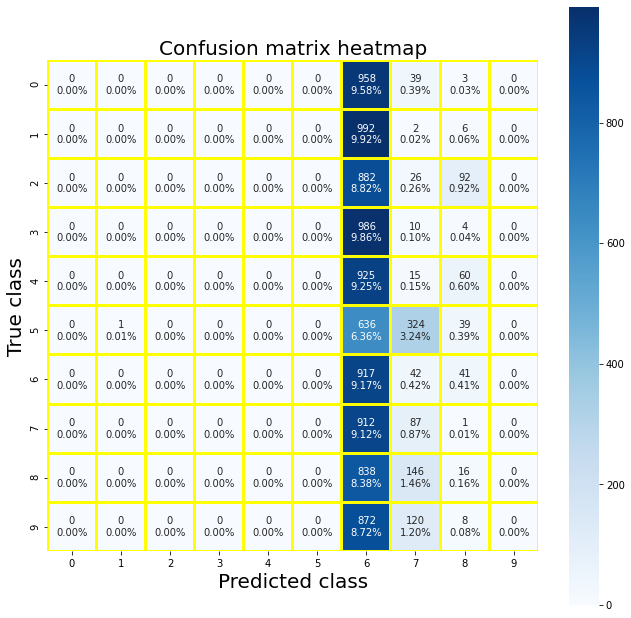

In [56]:
def predict(X_test,y_test):
  _,_,y_hat=forwardPropagation(X_test,parameters)
  y_hat=y_hat.argmax(axis=0)
  correctPred=np.sum(y_hat==y_test)
  print("Accuracy is ", correctPred/X_test.shape[0]*100,"%")
  return y_hat
y_pred=predict(X_test,y_test)
conf=confusion_matrix(y_test,y_pred)
print(conf)
#flatten the matrix 
numbers=conf.flatten()
#convert to percentage
percent=['{0:.2%}'.format(num) for num in numbers/np.sum(conf)]
p=plt.figure(figsize=(11,11))
#zip it 
values =[f'{num}\n{perc}' for num,perc in zip(numbers,percent)]
values=np.asarray(values).reshape(10,10)
sns.heatmap(conf,fmt='',annot=values,cmap='Blues',linewidths=2,linecolor="yellow",square=True)
plt.ylabel("True class",size=20)
plt.xlabel('Predicted class',size=20)
plt.title("Confusion matrix heatmap",size=20)
#wandb.init()
wandb.log({"Confusion matrix": [wandb.Image(p, caption="Confusion matrix")]})
plt.show()